In [1]:
import csv
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, Lambda, Conv2D, MaxPooling2D, Activation
from keras.regularizers import l2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.layers.advanced_activations import ELU
from keras.callbacks import ModelCheckpoint, Callback
  

Using TensorFlow backend.


In [2]:
data_dir = '../data/data/'
# data_dir = '../data_xc/'
col_csvnames = ['center_image', 'left_image', 'right_image', 'steering', 'throttle', 'brake', 'speed']
data = pd.read_csv(data_dir + 'driving_log_modified_xc.csv',skiprows = 1, names = col_csvnames)
data['center_image'] = data['center_image'].map(str.strip)
data['left_image'] = data['left_image'].map(str.strip)
data['right_image'] = data['right_image'].map(str.strip)

center = data.center_image.tolist()
center_recover = center
left = data.left_image.tolist()
right = data.right_image.tolist()
steering_measurements = data.steering.tolist()
steering_measurements_recover = steering_measurements

center, steering_measurements = shuffle(center, steering_measurements)
center, X_valid, steering_measurements, y_valid = train_test_split(center, steering_measurements, test_size = 0.20, random_state = 8)

In [3]:
def image_crop(image):
    # original shape: 160x320x3 - below is the cropping area
    # 60 rows pixels from the top of the image
    # 20 rows pixels from the bottom of the image
    # 0 columns of pixels from the left of the image
    # 0 columns of pixels from the right of the image
    new_image = image[60:140,:,:]
    
    return new_image

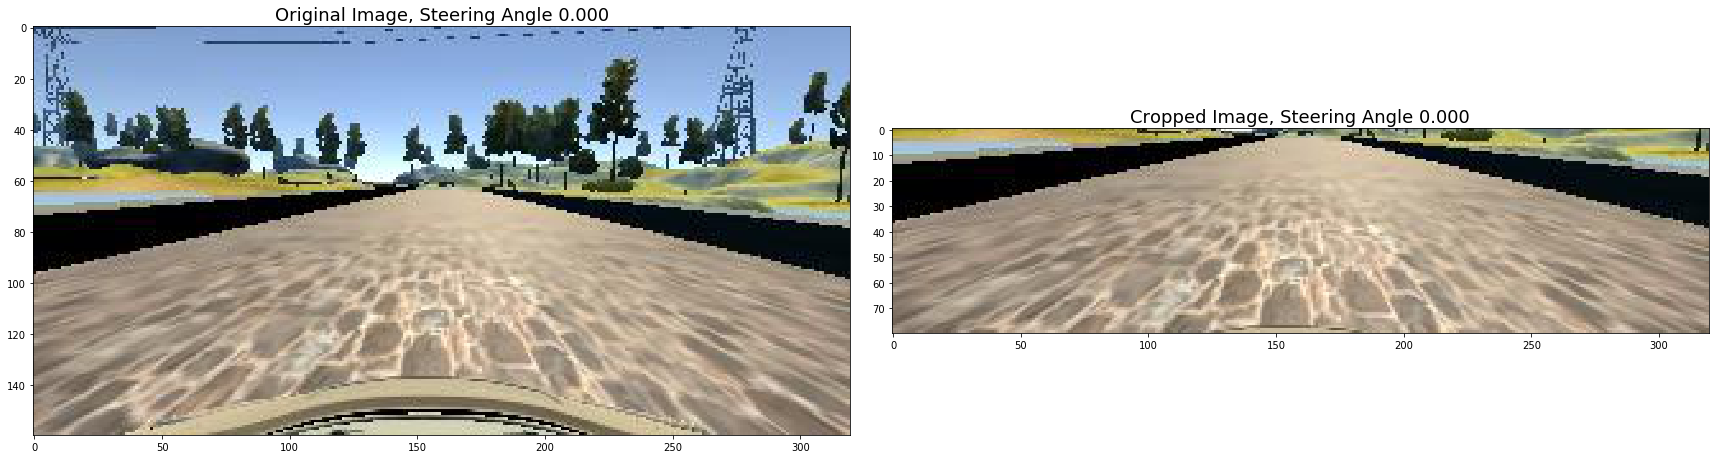

In [4]:
### Check to see how the image crop function works
imageX1_path = data_dir + center[6]
testImg = cv2.imread(imageX1_path)
testImg_cropped = image_crop(testImg)

# # # Plot the gaussian noise image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(testImg, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image, Steering Angle {0:.3f}'.format(steering_measurements[6]), fontsize=18)

ax2.imshow(cv2.cvtColor(testImg_cropped, cv2.COLOR_BGR2RGB))
ax2.set_title('Cropped Image, Steering Angle {0:.3f}'.format(steering_measurements[6]), fontsize=18)
plt.show()

In [5]:
def image_resize(image):
    new_image = cv2.resize(image,(200, 66), interpolation = cv2.INTER_AREA)
    return new_image

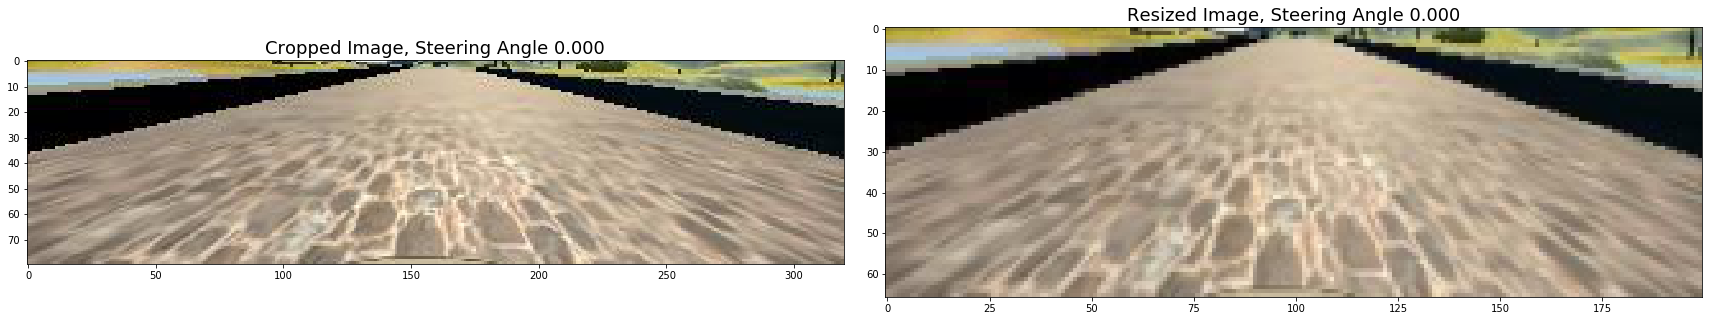

In [6]:
### Check to see how the image resize function works
testImg_resized = image_resize(testImg_cropped)
# # # Plot the gaussian noise image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(testImg_cropped, cv2.COLOR_BGR2RGB))
ax1.set_title('Cropped Image, Steering Angle {0:.3f}'.format(steering_measurements[6]), fontsize=18)

ax2.imshow(cv2.cvtColor(testImg_resized, cv2.COLOR_BGR2RGB))
ax2.set_title('Resized Image, Steering Angle {0:.3f}'.format(steering_measurements[6]), fontsize=18)
plt.show()

In [7]:
def image_flip(image, angle):
    new_image = cv2.flip(image,1)
    new_angle = angle*(-1)
    return new_image, new_angle

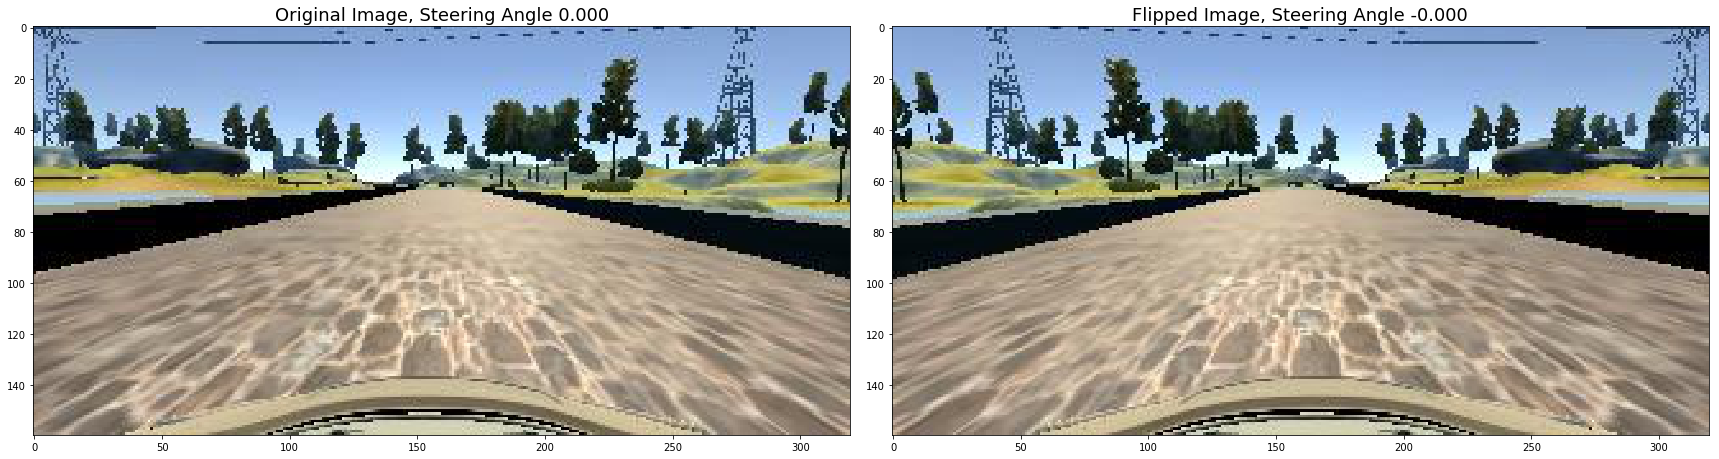

In [8]:
### Check to see how the image flip function works
imageX1_path = data_dir + center[6]
testImg = cv2.imread(imageX1_path)

testImg_flipped, angle_flipped = image_flip(testImg, steering_measurements[6])

# # # Plot the gaussian noise image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(testImg, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image, Steering Angle {0:.3f}'.format(steering_measurements[6]), fontsize=18)

ax2.imshow(cv2.cvtColor(testImg_flipped, cv2.COLOR_BGR2RGB))
ax2.set_title('Flipped Image, Steering Angle {0:.3f}'.format(angle_flipped), fontsize=18)
plt.show()

In [9]:
def random_brightness(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv[:,:,2] = hsv[:,:,2] * random.uniform(0.3, 1.0)
    new_image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return new_image

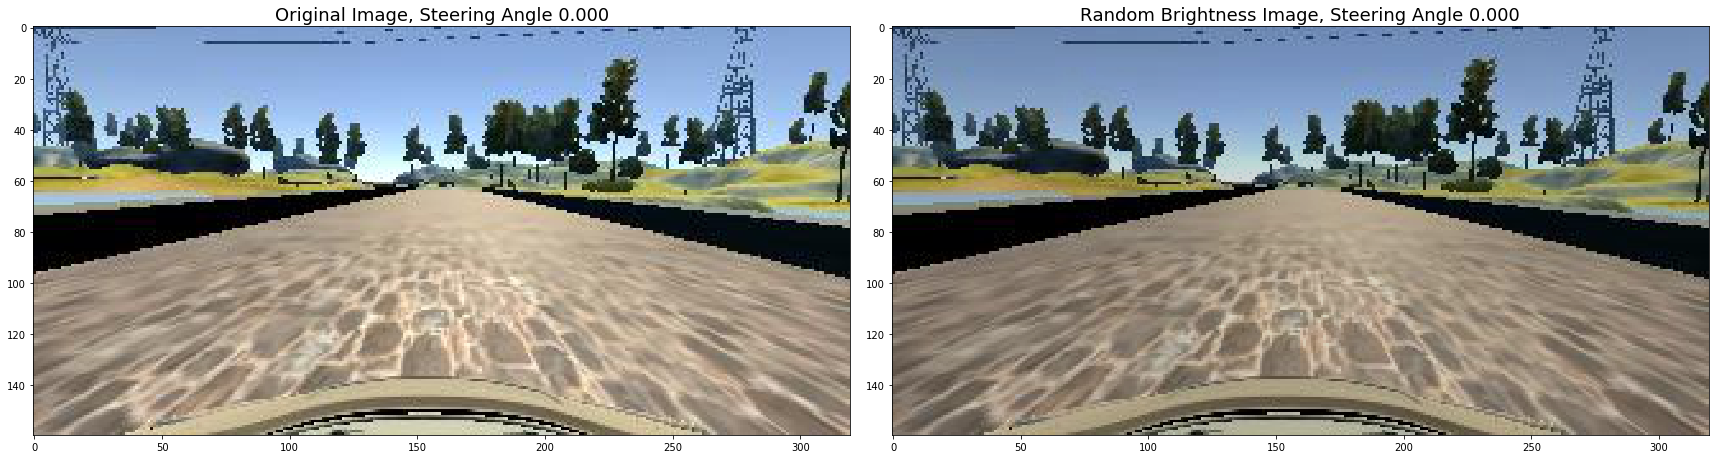

In [10]:
### Check to see how the image random_brightness function works
imageX1_path = data_dir + center[6]
testImg = cv2.imread(imageX1_path)
testImg_randomBrightness = random_brightness(testImg)


# # # Plot the gaussian noise image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(testImg, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image, Steering Angle {0:.3f}'.format(steering_measurements[6]), fontsize=18)

ax2.imshow(cv2.cvtColor(testImg_randomBrightness, cv2.COLOR_BGR2RGB))
ax2.set_title('Random Brightness Image, Steering Angle {0:.3f}'.format(steering_measurements[6]), fontsize=18)
plt.show()

In [11]:
def gaussian_blur(image):
    new_img = cv2.GaussianBlur(image, (3,3), 0)
    return new_img

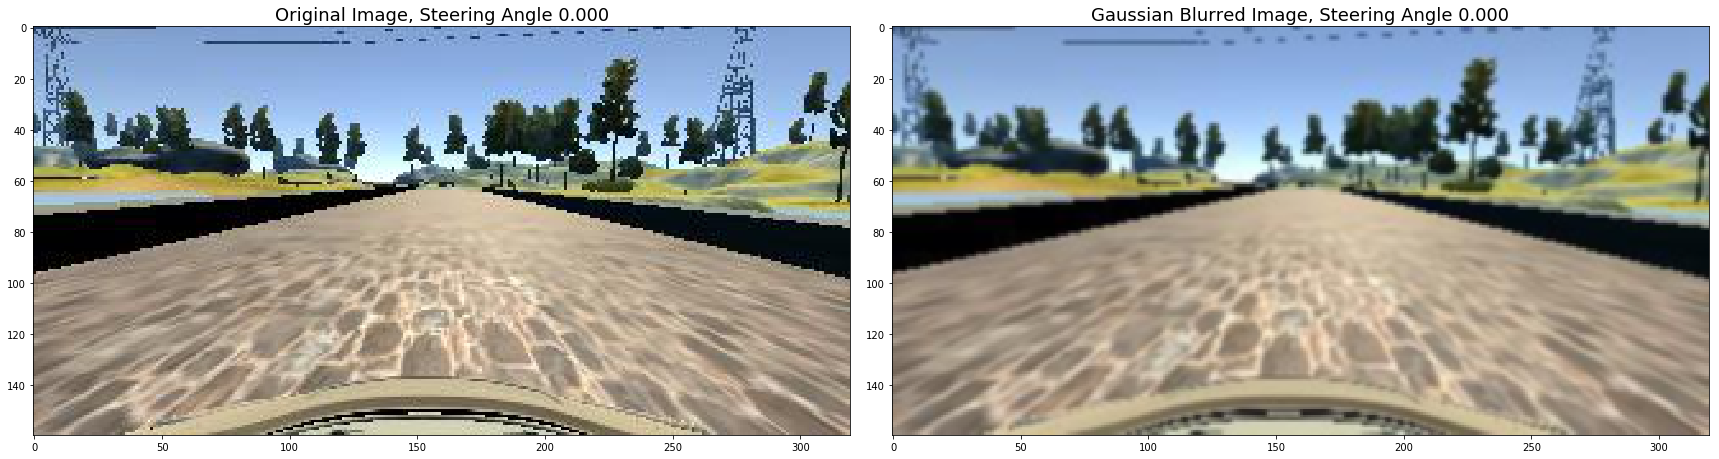

In [12]:
### Check to see how the image random_brightness function works
imageX1_path = data_dir + center[6]
testImg = cv2.imread(imageX1_path)
testImg_gaussian_blur = gaussian_blur(testImg)


# # # Plot the gaussian noise image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(testImg, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image, Steering Angle {0:.3f}'.format(steering_measurements[6]), fontsize=18)

ax2.imshow(cv2.cvtColor(testImg_gaussian_blur, cv2.COLOR_BGR2RGB))
ax2.set_title('Gaussian Blurred Image, Steering Angle {0:.3f}'.format(steering_measurements[6]), fontsize=18)
plt.show()

In [13]:
def trans_image(image,angle,trans_range = 50, trans_y=False):

    #translate image and compensate for the translation on the steering angle
    rows, cols, chan = image.shape
    # horizontal translation with 0.008 steering compensation per pixel
    if angle <=0: 
        tr_x = trans_range*(np.random.uniform(0,0.5)-0.5)
    else:
        tr_x = trans_range*(np.random.uniform(0.5,1)-0.5)
        
    angle_trans = angle + tr_x *0.008

    # option to disable vertical translation (vertical translation not necessary)
    if trans_y:
        tr_y = 50*(np.random.uniform()-0.5)
    else:
        tr_y = 0
    
    M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    image_trans = cv2.warpAffine(image,M,(cols,rows))

    return image_trans,angle_trans

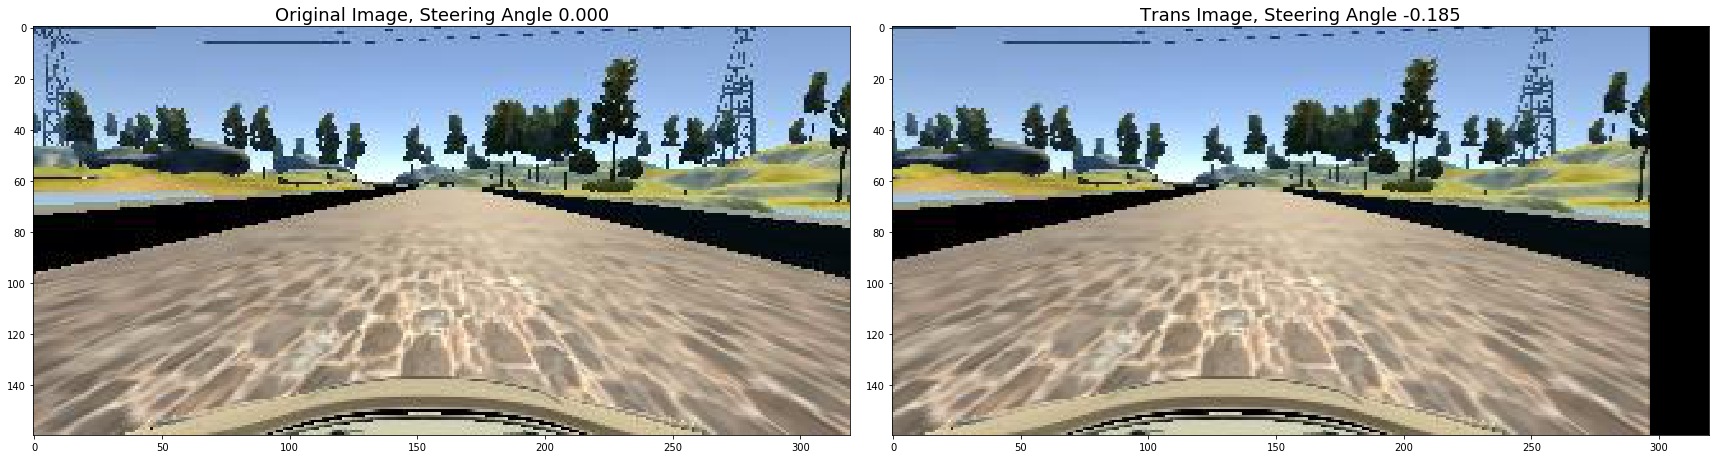

In [14]:
### Check to see how the image trans_image function works
imageX1_path = data_dir + center[6]
testImg = cv2.imread(imageX1_path)

testImage_trans, angle_trans = trans_image(testImg, steering_measurements[6])

# # # Plot the gaussian noise image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(testImg, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image, Steering Angle {0:.3f}'.format(steering_measurements[6]), fontsize=18)

ax2.imshow(cv2.cvtColor(testImage_trans, cv2.COLOR_BGR2RGB))
ax2.set_title('Trans Image, Steering Angle {0:.3f}'.format(angle_trans), fontsize=18)
plt.show()

In [15]:
def image_warp(image, angle):

    # Warp image horizontally, calculate the angle shifted then append to orig angle.
    WARP_DIV_RATIO = 5
    rows,cols,ch = image.shape
    
    # shifts within 1/(WARP_DIV_RATIO) of image width
    shifted_pixel = random.randint(-1*cols//WARP_DIV_RATIO,cols//WARP_DIV_RATIO)
    pts1 = np.float32([[cols//2,0],[0,rows-1],[cols-1,rows-1]])
    pts2 = np.float32([[cols//2+shifted_pixel,0],[0,rows-1],[cols-1,rows-1]])
    

    delta_angle = 0.004*shifted_pixel
    angle_corrected = angle + delta_angle
    
    M = cv2.getAffineTransform(pts1,pts2)
    image_warped = cv2.warpAffine(image, M,(cols,rows))
    
    return image_warped, angle_corrected

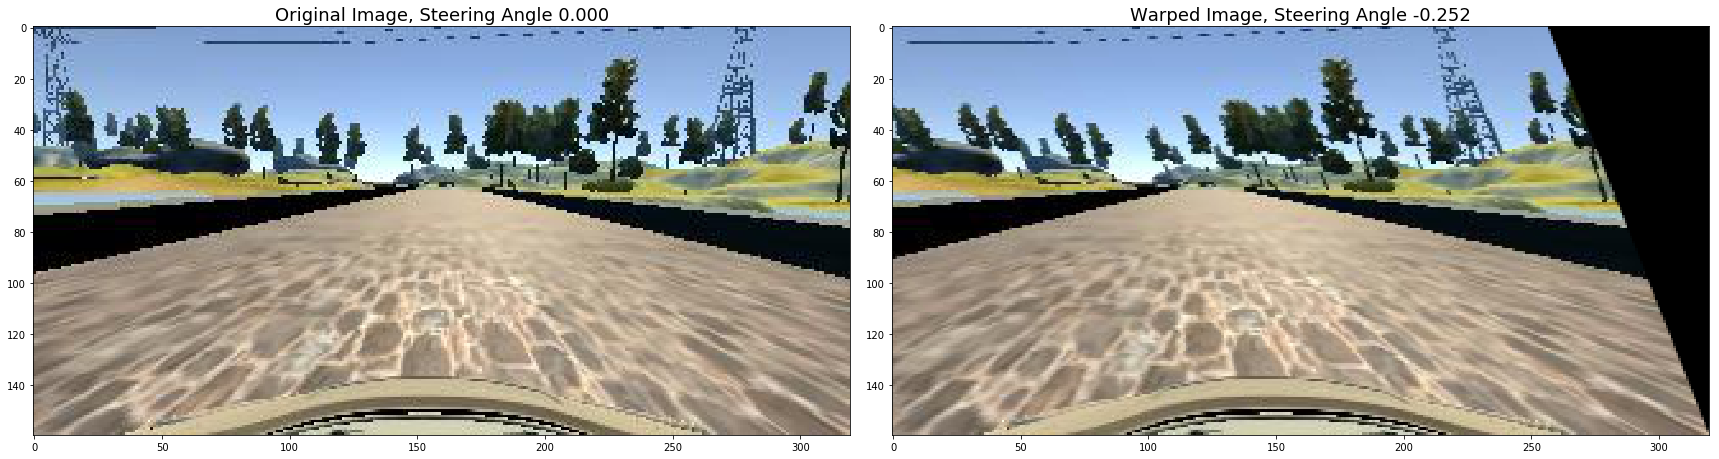

In [16]:
### Check to see how the image warp function works
imageX1_path = data_dir + center[6]
testImg = cv2.imread(imageX1_path)

testImage_warped, angle_warped = image_warp(testImg, steering_measurements[6])

# # # Plot the gaussian noise image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(testImg, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image, Steering Angle {0:.3f}'.format(steering_measurements[0]), fontsize=18)

ax2.imshow(cv2.cvtColor(testImage_warped, cv2.COLOR_BGR2RGB))
ax2.set_title('Warped Image, Steering Angle {0:.3f}'.format(angle_warped), fontsize=18)
plt.show()

In [17]:
def training_data_altogether(center, right, left, steering_measurements):
    img_paths = []
    steering_angles = []
    for steering in steering_measurements:
        idx = steering_measurements.index(steering)
        img_paths.append(left[idx])
        steering_angles.append(steering + 0.25)
        img_paths.append(right[idx])
        steering_angles.append(steering - 0.25)        
        img_paths.append(center[idx])
        steering_angles.append(steering)
    return img_paths, steering_angles
    

In [18]:
img_paths, steering_angles = training_data_altogether(center, right, left, steering_measurements)

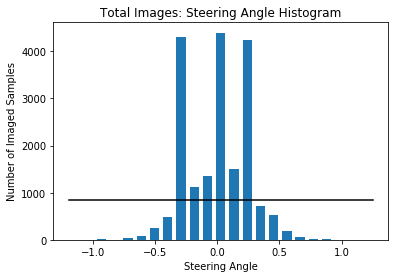

In [19]:
## to show the steering angle histogram from the training set
num_bins = 23
avg_samples_per_bin = len(steering_angles)/num_bins

hist, bins = np.histogram(steering_angles, bins=num_bins)
width = 0.7 * (bins[1] - bins[0])
bar_center = (bins[:-1] + bins[1:]) / 2
plt.bar(bar_center, hist, align='center', width=width)
plt.plot((np.min(steering_angles), np.max(steering_angles)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')
plt.title("Total Images: Steering Angle Histogram")
plt.xlabel("Steering Angle")
plt.ylabel("Number of Imaged Samples")
plt.show()

In [20]:
keep_bins = []
target = avg_samples_per_bin * 2.0
for i in range(num_bins):
    if hist[i] < target:
        keep_bins.append(1.0)
    else:
        keep_bins.append(target/hist[i])
        
remove_list = []
for i in range(len(steering_angles)):
    for j in range(num_bins):
        if steering_angles[i] > bins[j] and steering_angles[i] <= bins[j+1]:
            if np.random.rand()>keep_bins[j]:
                remove_list.append(i)
img_paths = np.delete(img_paths,remove_list, axis = 0)
steering_angles = np.delete(steering_angles, remove_list)
                
        

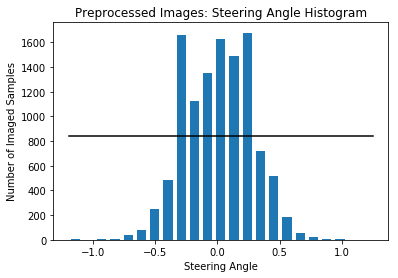

In [21]:
hist, bins = np.histogram(steering_angles, bins=num_bins)
width = 0.7 * (bins[1] - bins[0])
bar_center = (bins[:-1] + bins[1:]) / 2
plt.bar(bar_center, hist, align='center', width=width)
plt.plot((np.min(steering_angles), np.max(steering_angles)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')
plt.title("Preprocessed Images: Steering Angle Histogram")
plt.xlabel("Steering Angle")
plt.ylabel("Number of Imaged Samples")
plt.show()

In [22]:
def right_left_straight_SteeringClassifier(center, steering_measurements, steering_threshold = 0.15):
    img_straight, img_left, img_right = [], [], []
    steering_straight, steering_left, steering_right = [], [], []
    
    # steering angle: positive is from left to right. negative is from right to left
    for steering in steering_measurements:
        idx = steering_measurements.index(steering)
        if steering > steering_threshold:
            img_right.append(center[idx])
            steering_right.append(steering)
        elif steering < -steering_threshold:
            img_left.append(center[idx])
            steering_left.append(steering)
        else:
            img_straight.append(center[idx])
            steering_straight.append(steering)  
            
    return img_straight, steering_straight, img_left, steering_left, img_right, steering_right 


In [23]:
steering_threshold = 0.25
img_paths = img_paths.tolist()
steering_angles = steering_angles.tolist()
img_straight, steering_straight, img_left, steering_left, img_right, steering_right = right_left_straight_SteeringClassifier(img_paths, steering_angles, steering_threshold)

In [24]:
## recovery data
number_img_straight, number_img_left, number_img_right = len(img_straight), len(img_left), len(img_right) 
number_center_recover = len(center_recover)
number_img_left_append =  number_img_straight - number_img_left
number_img_right_append =  number_img_straight - number_img_right

index_left_append = random.sample(range(number_center_recover), number_img_left_append)
index_right_append = random.sample(range(number_center_recover), number_img_right_append)

steering_adjustment = 0.25

# If steering angle less than -steering_threshold, then add right camera images into driving left list, minus an adjustment angle #
for idx in index_left_append:
    if steering_measurements_recover[idx] < -steering_threshold:
        img_left.append(right[idx])
        steering_left.append(steering_measurements_recover[idx] - steering_adjustment)

# If steering angle more than +steering_threshold, then add left camera images into driving right list, add an adjustment angle #  
for idx in index_right_append:
    if steering_measurements_recover[idx] > steering_threshold:
        img_right.append(left[idx])
        steering_right.append(steering_measurements_recover[idx] + steering_adjustment)


In [25]:
img_paths = img_straight + img_left + img_right
steering_angles = np.float32(steering_straight + steering_left + steering_right)
X_train = img_paths
y_train = steering_angles

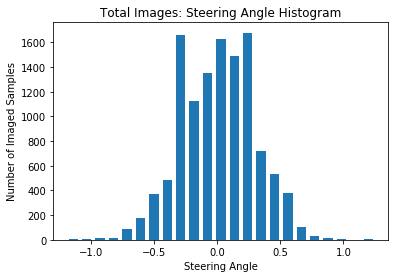

In [26]:
## to show the steering angle histogram from the training set
hist, bins = np.histogram(y_train, bins=num_bins)
width = 0.7 * (bins[1] - bins[0])
bar_center = (bins[:-1] + bins[1:]) / 2
plt.bar(bar_center, hist, align='center', width=width)

plt.title("Total Images: Steering Angle Histogram")
plt.xlabel("Steering Angle")
plt.ylabel("Number of Imaged Samples")
plt.show()

In [27]:
def generator_data_train(batch_size, X, y):

    batch_train = np.zeros((batch_size, 66, 200, 3), dtype = np.float32)
    batch_angle = np.zeros((batch_size,), dtype = np.float32)
    while True:
        image, angle = shuffle(X, y)
        for i in range(batch_size):
            choice = int(np.random.choice(len(image),1,replace=False))
            path_image = data_dir + image[choice]
            
            image_read = cv2.imread(path_image)
            batch_angle[i] = angle[choice]
            
            # random brightness
            image_read = random_brightness(image_read)
            
            # translate the image
            flip_coin = random.randint(0,4)
            if flip_coin == 0:
                image_read, batch_angle[i] = trans_image(image_read, batch_angle[i])
            elif flip_coin == 1:
                # warp the image
                image_read, batch_angle[i] = image_warp(image_read, batch_angle[i])
            
            # Gaussian Blur Image
            image_read = gaussian_blur(image_read) 
            
            # cropped the image
            img_cropped = image_crop(image_read)
            
            # resize the image same as NVIDIA CNN model input
            batch_train[i] = image_resize(img_cropped)
            # batch_angle[i] = batch_angle[i]*(1+ np.random.uniform(-0.10,0.10))
            
            # flip the image
            flip_coin = random.randint(0,1)
            if flip_coin == 1:
                batch_train[i], batch_angle[i] = image_flip(batch_train[i], batch_angle[i])
          

            # convert the image to YUV plane as NVIDIA CNN model input 
            batch_train[i] = cv2.cvtColor(batch_train[i], cv2.COLOR_BGR2YUV)
            
        yield batch_train, batch_angle

In [28]:
def generator_data_valid(batch_size, X, y):

    batch_train = np.zeros((batch_size, 66, 200, 3), dtype = np.float32)
    batch_angle = np.zeros((batch_size,), dtype = np.float32)
    while True:
        image, angle = shuffle(X, y)
        for i in range(batch_size):
            choice = int(np.random.choice(len(image),1,replace=False))
            path_image = data_dir + image[choice]
            # cropped the image
            img_cropped = image_crop(cv2.imread(path_image))
            
            # Gaussian Blur Image
            img_cropped = gaussian_blur(img_cropped) 
            
            # resize the image same as NVIDIA CNN model input
            batch_train[i] = image_resize(img_cropped)
            batch_angle[i] = angle[choice]
            # convert the image to YUV plane as NVIDIA CNN model input 
            batch_train[i] = cv2.cvtColor(batch_train[i], cv2.COLOR_BGR2YUV)
            
        yield batch_train, batch_angle

In [29]:
batch_size = 64
train_generator = generator_data_train(batch_size, X_train, y_train)
validation_generator = generator_data_valid(batch_size, X_valid, y_valid)
num_X_train = len(X_train)
num_X_valid = len(X_valid)

In [30]:
def model_NVIDIA(train_generator, validation_generator):
    model = Sequential()
    model.add(Lambda(lambda x: (x/255.0) - 0.5, input_shape=(66,200,3)))
    model.add(Conv2D(24, (5, 5), strides=(2, 2), padding='valid', kernel_regularizer=l2(0.001)))
    model.add(ELU())
    model.add(Conv2D(36, (5, 5), strides=(2, 2), padding='valid', kernel_regularizer=l2(0.001)))
    model.add(ELU())
    model.add(Conv2D(48, (5, 5), strides=(2, 2), padding='valid', kernel_regularizer=l2(0.001)))
    model.add(ELU())
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001)))
    model.add(ELU())
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001)))
    model.add(ELU())
    model.add(Flatten())
    model.add(Dense(100))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Dense(50))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Dense(10))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.compile(optimizer=Adam(lr=0.001), loss='mse')
    model.summary()
    
    checkpoint = ModelCheckpoint('model_{epoch:02d}.h5')
    model.fit_generator(train_generator, steps_per_epoch = int(num_X_train), epochs= 6,validation_data = validation_generator, validation_steps = int(num_X_valid),callbacks=[checkpoint])
    model.save('model.h5')
    
    return model
    

In [31]:
model_steering = model_NVIDIA(train_generator, validation_generator)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
elu_1 (ELU)                  (None, 31, 98, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
elu_2 (ELU)                  (None, 14, 47, 36)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
elu_3 (ELU)                  (None, 5, 22, 48)         0         
__________

In [32]:
print('THE END')

THE END
